In [56]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%matplotlib inline

In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (6,4)
plt.rcParams['figure.dpi'] = 150

In [4]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [5]:
import Actuator_force as af

In [153]:
af.print_stats()

F_nut: 184.07412836013265
F_act: 516.5249561399658
w_max: 83.23722746051511
theta_min: 5.46502379990588
E_ratio: 7.011947373034118
Min Length: 23.98181808768893
Max Length: 196.20703583268897
I_stage1: 0.8630697997090299
I_stage2: 0.9022791988361196
I_base: 2.6153489985451497
alpha: 0.15707963267948966
F_app Grav Approximation: 14.082378428298632


In [9]:
af.w_l(af.L_max, af.l_bent, af.l_r, af.l_total)

24.049483010402337

In [38]:
def plot_w(l_b, l_o):
    l = np.arange(af.L_min, af.L_max, 1)
    w = [af.w_l(L, l_b, l_o, af.l_total) for L in l]
    plt.plot(w,l)
interact(plot_w, l_b = (0, 15, 0.5), l_o = (af.l_r/1.5, af.l_r*1.5, 1) )

interactive(children=(FloatSlider(value=7.0, description='l_b', max=15.0, step=0.5), FloatSlider(value=45.0, d…

<function __main__.plot_w(l_b, l_o)>

In [134]:
def plot_L_theta(l_b, l_o, color):
    l_total = af.l_r*4 + l_o
    
    for i in np.linspace(af.theta_min(l_o), np.pi/2):
        w_min =  af.w_theta(i, l_o, l_total)
        if w_min<af.w_min:
            theta_max = i
            break
    
    print(theta_max, af.theta_min(l_o))
    theta = np.arange(af.theta_min(l_o), theta_max, 0.01)
    w = [af.w_theta(th, l_o, l_total) for th in theta]
    l  = [af.L_theta(th, l_b, l_total) for th in theta]
    plt.plot(w,l, color)
    return l,w
interact(plot_L_theta, l_b = (0, 15, 0.5), l_o = (af.l_r/1.5, af.l_r*1.5, 1), color = 'r' )

interactive(children=(FloatSlider(value=7.0, description='l_b', max=15.0, step=0.5), FloatSlider(value=45.0, d…

<function __main__.plot_L_theta(l_b, l_o, color)>

1.2395810136182932 0.09538265900820937
1.1015506982610337 0.13373158940994154
1.2969923120836488 0.08008558003365901


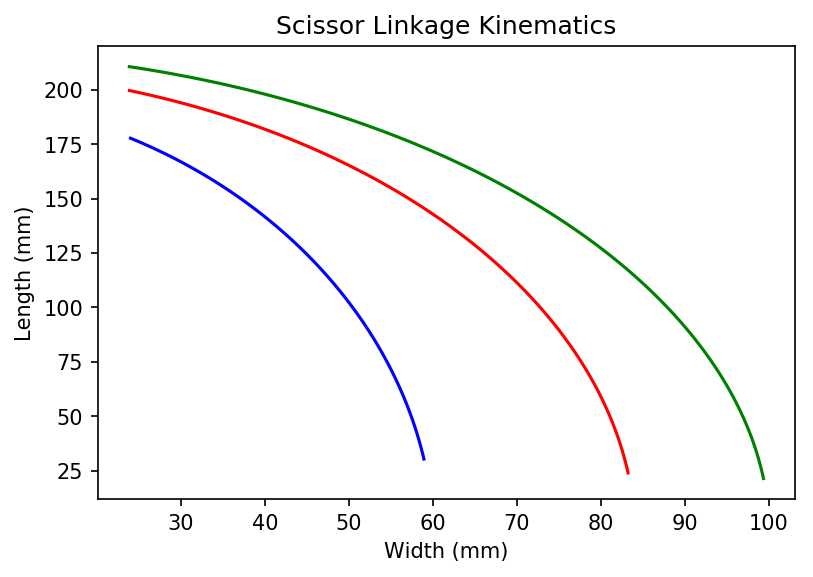

In [135]:
l1, w1 = plot_L_theta(4, 42, 'r')
l2, w2 = plot_L_theta(4, 30, 'b')
l3, w3 = plot_L_theta(4, 50, 'g')
plt.title("Scissor Linkage Kinematics")
plt.ylabel("Length (mm)")
plt.xlabel("Width (mm)")
plt.savefig("ScissorK.png")

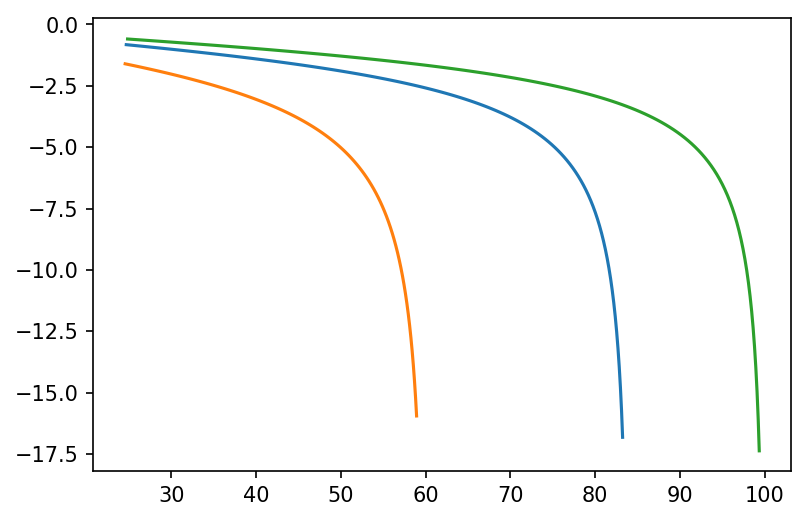

In [133]:
def plot_dL(l,w):
    dL = []
    for i in range(len(l) - 1):
        dL.append( (l[i+1] - l[i])/(w[i+1] - w[i]) )
    plt.plot(w[0:-1], dL)  
plot_dL(l1,w1)
plot_dL(l2,w2)
plot_dL(l3,w3)

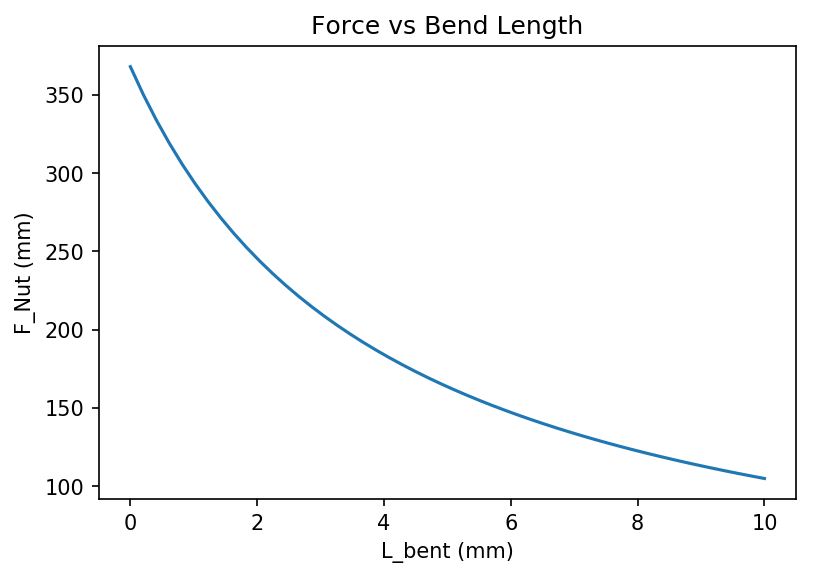

In [156]:
lb = np.linspace(0, 10)
F = [af.F_nut(af.theta_min(af.l_r),af.F_app, l_b, af.l_r, af.l_total ) for l_b in lb]
plt.plot(lb, F)
plt.xlabel("L_bent (mm)")
plt.ylabel("F_Nut (mm)")
plt.title("Force vs Bend Length")
plt.savefig("f_bent.png")

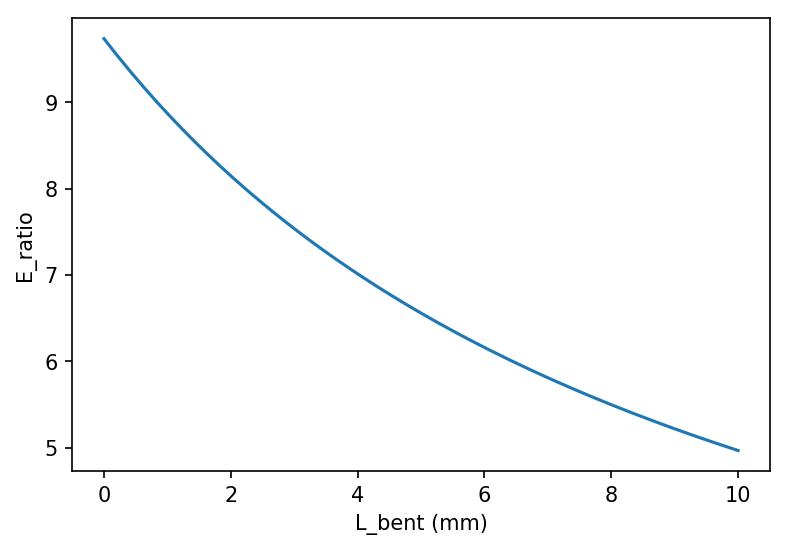

In [155]:
E_ratio = [af.E_ratio(l_b, af.l_r, af.l_total) for l_b in lb]

plt.plot(lb, E_ratio)
plt.xlabel("L_bent (mm)")
plt.ylabel("E_ratio")
plt.savefig("e_ratio.png")

In [151]:
%autoreload

<function Actuator_force.E_ratio(l_b, l_o, l_total)>